In [8]:
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import os
from funcs import sMAPE

In [2]:
tf.random.set_seed(69)
random.seed(69)
np.random.seed(69)
os.environ["PYTHONHASHSEED"] = str(69)

In [27]:
def multiStepSampler(df, window, door):
    xRes = []
    yRes = []
    for i in range(0, len(df)-window-door):
        res = []
        for j in range(0, window):
            res.append([df.Price[i+j]])
        xRes.append(res)
        yRes.append(df.Price[i+window:i+window+door])
    return (tf.convert_to_tensor(xRes), tf.convert_to_tensor(yRes))

In [5]:
df = pd.read_csv('./data/daily.csv')
df.head()

,Day,Price
0,19970107,3.82
1,19970108,3.80
2,19970109,3.61
3,19970110,3.92
4,19970113,4.00


In [11]:
def smape(y_true, y_pred):
    epsilon = 0.1
    summ = K.maximum(K.abs(y_true) + K.abs(y_pred) + epsilon, 0.5 + epsilon)
    smape = K.abs(y_pred - y_true) / summ * 2.0
    return smape

In [28]:
SPLIT = 0.85
xVal, yVal = multiStepSampler(df, 60, 30)
xTrain = xVal[:int(SPLIT*len(xVal))]
yTrain = yVal[:int(SPLIT*len(yVal))]
xTest = xVal[int(SPLIT*len(xVal)):]
yTest = yVal[int(SPLIT*len(yVal)):]
(xTrain.shape, xTest.shape)

(TensorShape([5350, 60, 1]), TensorShape([945, 60, 1]))

In [84]:
hybridModel = tf.keras.Sequential()
hybridModel.add(tf.keras.layers.Conv1D(32, kernel_size=(3), input_shape=(60, 1)))
hybridModel.add(tf.keras.layers.MaxPool1D(pool_size=3, strides=(1), padding='valid'))
hybridModel.add(tf.keras.layers.LSTM(256, return_sequences=True))
hybridModel.add(tf.keras.layers.Flatten())
hybridModel.add(tf.keras.layers.Dense(128, activation='relu'))
hybridModel.add(tf.keras.layers.Dense(30, activation='linear'))
hybridModel.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), metrics=['mse', 'mae', smape])

In [85]:
hybridModel.fit(xTrain, yTrain, epochs=30)

Epoch 1/30
168/168 [==============================] - 5s 18ms/step - loss: 2.5944 - mse: 11.9948 - mae: 2.5944 - smape: 0.9154
Epoch 2/30
168/168 [==============================] - 3s 17ms/step - loss: 1.2700 - mse: 4.1521 - mae: 1.2700 - smape: 0.3466
Epoch 3/30
168/168 [==============================] - 3s 17ms/step - loss: 0.8181 - mse: 1.6366 - mae: 0.8181 - smape: 0.1780
Epoch 4/30
168/168 [==============================] - 3s 18ms/step - loss: 0.6815 - mse: 1.1767 - mae: 0.6815 - smape: 0.1440
Epoch 5/30
168/168 [==============================] - 3s 18ms/step - loss: 0.6516 - mse: 1.0860 - mae: 0.6516 - smape: 0.1369
Epoch 6/30
168/168 [==============================] - 3s 20ms/step - loss: 0.6366 - mse: 1.0378 - mae: 0.6366 - smape: 0.1337
Epoch 7/30
168/168 [==============================] - 3s 18ms/step - loss: 0.6234 - mse: 1.0036 - mae: 0.6234 - smape: 0.1309
Epoch 8/30
168/168 [==============================] - 3s 19ms/step - loss: 0.6119 - mse: 0.9704 - mae: 0.6119 - smape

In [74]:
LSTMModel = tf.keras.Sequential()
LSTMModel.add(tf.keras.layers.LSTM(256, return_sequences=True, input_shape=(60, 1)))
LSTMModel.add(tf.keras.layers.Flatten())
LSTMModel.add(tf.keras.layers.Dense(128, activation='relu'))
LSTMModel.add(tf.keras.layers.Dense(30, activation='linear'))
LSTMModel.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(), metrics=['mse', 'mae', smape])

In [75]:
LSTMModel.fit(xTrain, yTrain, epochs=30)

Epoch 1/30
168/168 [==============================] - 5s 19ms/step - loss: 0.7497 - mse: 1.6055 - mae: 0.7497 - smape: 0.1766
Epoch 2/30
168/168 [==============================] - 3s 18ms/step - loss: 0.5374 - mse: 0.7557 - mae: 0.5374 - smape: 0.1150
Epoch 3/30
168/168 [==============================] - 3s 17ms/step - loss: 0.5097 - mse: 0.7015 - mae: 0.5097 - smape: 0.1092
Epoch 4/30
168/168 [==============================] - 3s 17ms/step - loss: 0.4866 - mse: 0.6515 - mae: 0.4866 - smape: 0.1045
Epoch 5/30
168/168 [==============================] - 3s 18ms/step - loss: 0.4817 - mse: 0.6350 - mae: 0.4817 - smape: 0.1039
Epoch 6/30
168/168 [==============================] - 3s 18ms/step - loss: 0.4722 - mse: 0.6133 - mae: 0.4722 - smape: 0.1025
Epoch 7/30
168/168 [==============================] - 3s 18ms/step - loss: 0.4621 - mse: 0.6007 - mae: 0.4621 - smape: 0.1002
Epoch 8/30
168/168 [==============================] - 3s 17ms/step - loss: 0.4659 - mse: 0.5993 - mae: 0.4659 - smape:

In [71]:
CNNModel = tf.keras.Sequential()
CNNModel.add(tf.keras.layers.Conv1D(32, kernel_size=(2), input_shape=(60, 1)))
CNNModel.add(tf.keras.layers.Flatten())
CNNModel.add(tf.keras.layers.Dense(128, activation='relu'))
CNNModel.add(tf.keras.layers.Dense(30, activation='linear'))
CNNModel.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(), metrics=['mse', 'mae', smape])

In [72]:
CNNModel.fit(xTrain, yTrain, epochs=30)

Epoch 1/30
168/168 [==============================] - 1s 5ms/step - loss: 0.7224 - mse: 1.5344 - mae: 0.7224 - smape: 0.1655
Epoch 2/30
168/168 [==============================] - 1s 4ms/step - loss: 0.5484 - mse: 0.8005 - mae: 0.5484 - smape: 0.1160
Epoch 3/30
168/168 [==============================] - 1s 4ms/step - loss: 0.5264 - mse: 0.7693 - mae: 0.5264 - smape: 0.1110
Epoch 4/30
168/168 [==============================] - 1s 4ms/step - loss: 0.5151 - mse: 0.7452 - mae: 0.5151 - smape: 0.1086
Epoch 5/30
168/168 [==============================] - 1s 4ms/step - loss: 0.5145 - mse: 0.7388 - mae: 0.5145 - smape: 0.1087
Epoch 6/30
168/168 [==============================] - 1s 4ms/step - loss: 0.5141 - mse: 0.7335 - mae: 0.5141 - smape: 0.1087
Epoch 7/30
168/168 [==============================] - 1s 4ms/step - loss: 0.5010 - mse: 0.7146 - mae: 0.5010 - smape: 0.1057
Epoch 8/30
168/168 [==============================] - 1s 4ms/step - loss: 0.5101 - mse: 0.7215 - mae: 0.5101 - smape: 0.1080


In [86]:
hybridModel.evaluate(xTest, yTest)
LSTMModel.evaluate(xTest, yTest)
CNNModel.evaluate(xTest, yTest)

30/30 [==============================] - 0s 3ms/step - loss: 0.4452 - mse: 1.3273 - mae: 0.4452 - smape: 0.1268


[0.4451821744441986,
 1.3272572755813599,
 0.4451821744441986,
 0.1267676055431366]

<AxesSubplot:>

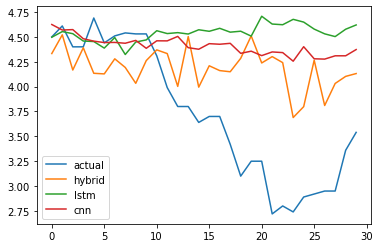

In [105]:
i = 100


hybrid = np.array(hybridModel.predict(np.array([xTest[i]]))).tolist()
lstm = np.array(LSTMModel.predict(np.array([xTest[i]]))).tolist()
cnn = np.array(CNNModel.predict(np.array([xTest[i]]))).tolist()

dafr = pd.DataFrame(data={'actual': np.array(yTest[i]).tolist(), 'hybrid': hybrid[0], 'lstm': lstm[0], 'cnn': cnn[0]})
dafr.plot()

In [106]:
CNNModel.save('./models/multiStepDailyCNN.h5')
LSTMModel.save('./models/multiStepDailyLSTM.h5')
hybridModel.save('./models/multiStepDailyHybrid.h5')